In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [8]:
# 데이터 불러오기 및 가공
data = pd.read_csv('merged_data_final2.csv')
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['Timestamp'] = data['Timestamp'].astype('int64') // 10**9
data = data[['Timestamp', 'DI_uiSpeed', 'DI_vehicleSpeed','Physical_value','acc_value']]

# 데이터 정규화
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)
print(f"data_normalized.shape: {data_normalized.shape}")

# 시퀀스 생성
sequence_length = 150  # 시퀀스 길이
X = []
y = []

# acc_value를 타겟으로 설정 (data_normalized의 마지막 열)
for i in range(len(data_normalized) - sequence_length):
    X.append(data_normalized[i:i+sequence_length, : -1])
    y.append(data_normalized[i+sequence_length, -1])  # acc_value를 타겟으로 사용

X = np.array(X)
y = np.array(y)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tensor 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# 데이터셋 및 데이터로더 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


data_normalized.shape: (10492, 5)


In [19]:
# LSTM 모델 정의
class LSTMBinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.7):
        super(LSTMBinaryClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # LSTM 레이어 정의
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)  # 출력 레이

    def forward(self, x):
        # LSTM의 초기 은닉 상태와 셀 상태 초기화
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # LSTM 레이어 통과 (h0, c0 초기 은닉 상태와 셀 상태)
        out, _ = self.lstm(x, (h0, c0))
        
        # 최종 LSTM 은닉 상태 출력만 사용
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝의 출력 사용
        return out

# 하이퍼파라미터 설정
input_size = 4  # 입력 피처의 개수 (Timestamp, DI_uiSpeed, DI_vehicleSpeed, Physical_value)
hidden_size = 128  # LSTM의 은닉 상태 크기
num_layers = 5  # LSTM 레이어 수
output_size = 1  # 이진분류 출력 크기
dropout = 0.7  # 드롭아웃 확률

# LSTM 모델 생성
model = LSTMBinaryClassifier(input_size, hidden_size, num_layers, output_size, dropout)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Epoch [1/70], Train Loss: 0.4186, Test Loss: 0.1140, Epoch Time: 22.06 seconds
-------------------------------------------------------
Epoch [2/70], Train Loss: 0.1121, Test Loss: 0.0927, Epoch Time: 21.30 seconds
-------------------------------------------------------
Epoch [3/70], Train Loss: 0.1003, Test Loss: 0.0842, Epoch Time: 21.41 seconds
-------------------------------------------------------
Epoch [4/70], Train Loss: 0.0907, Test Loss: 0.0797, Epoch Time: 20.91 seconds
-------------------------------------------------------
Epoch [5/70], Train Loss: 0.0874, Test Loss: 0.0740, Epoch Time: 21.63 seconds
-------------------------------------------------------
Epoch [6/70], Train Loss: 0.0834, Test Loss: 0.0842, Epoch Time: 21.47 seconds
-------------------------------------------------------
Epoch [7/70], Train Loss: 0.0865, Test Loss: 0.0605, Epoch Time: 20.97 seconds
-------------------------------------------------------
Epoch [8/70], Train Loss: 0.0794, Test Loss: 0.0681, Ep

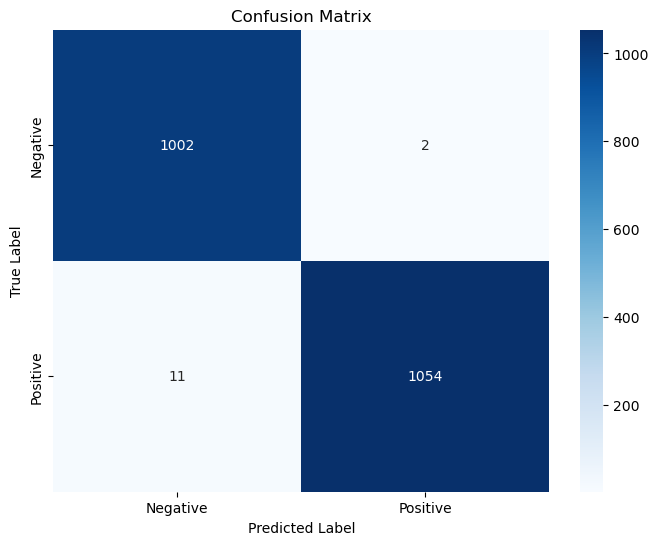

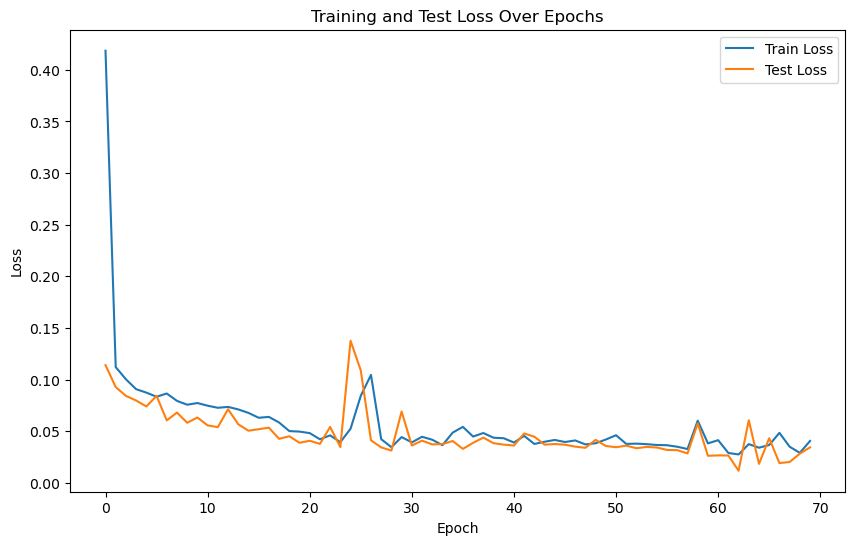

Test Accuracy: 0.9937, Test Precision: 0.9981, Test Recall: 0.9897, Test F1-Score: 0.9939, 


In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Confusion Matrix 그리기 함수
def plot_confusion_matrix(y_true, y_pred_label):
    cm = confusion_matrix(y_true, y_pred_label)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# 학습 및 평가 함수 정의
# 모델 학습 및 평가 함수 정의
def train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    global train_losses
    train_losses = []  # Train loss 저장 리스트
    global test_losses
    test_losses = []   # Test loss 저장 리스트
    
    # 전체 학습 시작 시간 기록
    total_start_time = time.time()
    
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_dataloader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
        
        epoch_loss = running_loss / len(train_dataloader.dataset)
        train_losses.append(epoch_loss)

        test_loss, test_accuracy, test_precision, test_recall, test_f1, y_true, y_pred_label = evaluate_model(model, test_dataloader, criterion)
        test_losses.append(test_loss)
        
        epoch_time = time.time() - start_time  # 에포크별 시간 계산
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_loss:.4f}, '
              f'Test Loss: {test_loss:.4f}, '
              f'Epoch Time: {epoch_time:.2f} seconds'
        )
        
        print("-------------------------------------------------------")
    
    # 전체 학습 시간 계산
    total_time = time.time() - total_start_time
    minutes, seconds = divmod(total_time, 60)
    print(f'Total training time: {int(minutes)} minutes and {seconds:.2f} seconds')
    
    return y_true, y_pred_label  # 최종적으로 y_true와 y_pred_label 반환


def evaluate_model(model, test_dataloader, criterion):
    model.eval()
    global accuracy
    global precision
    global recall
    global f1
    with torch.no_grad():
        test_loss = 0.0
        y_pred = []
        y_true = []
        for X_batch, y_batch in test_dataloader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item() * X_batch.size(0)
            
            # Sigmoid 적용 후 이진 분류
            y_pred.extend(torch.sigmoid(outputs).cpu().numpy())  # 여기에서 Sigmoid를 적용
            y_true.extend(y_batch.squeeze().cpu().numpy())

        
        test_loss = test_loss / len(test_dataloader.dataset)
        y_pred_label = (np.array(y_pred) >= 0.5).astype(int)
    
        
        # 평가 지표 계산
        accuracy = accuracy_score(y_true, y_pred_label)
        precision = precision_score(y_true, y_pred_label)
        recall = recall_score(y_true, y_pred_label)
        f1 = f1_score(y_true, y_pred_label)

        return test_loss, accuracy, precision, recall, f1, y_true, y_pred_label

def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss Over Epochs')
    plt.legend()
    plt.show()


# 모델 학습 및 평가
num_epochs = 70  # 에포크 수 조정 가능
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Train the model and get the true and predicted labels
y_true, y_pred_label = train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs)

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred_label)

plot_losses(train_losses, test_losses)

# 최종 평가 지표 출력
evaluate_model(model, test_dataloader, criterion)
print(
    f'Test Accuracy: {accuracy:.4f}, '
    f'Test Precision: {precision:.4f}, '
    f'Test Recall: {recall:.4f}, '
    f'Test F1-Score: {f1:.4f}, '
)

In [21]:
torch.save(model.state_dict(), 'model_weights2.pth')

In [22]:
import time  # 시간을 측정하기 위한 모듈

def evaluate_model(model, test_dataloader, criterion):
    model.eval()
    global accuracy
    global precision
    global recall
    global f1

    total_start_time = time.time()  # 전체 평가 시작 시간 기록

    with torch.no_grad():
        test_loss = 0.0
        y_pred = []
        y_true = []
        for X_batch, y_batch in test_dataloader:
            batch_start_time = time.time()  # 배치 시작 시간 기록
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item() * X_batch.size(0)

            # Sigmoid 적용 후 이진 분류
            y_pred.extend(torch.sigmoid(outputs).cpu().numpy())  # 여기에서 Sigmoid를 적용
            y_true.extend(y_batch.squeeze().cpu().numpy())

            batch_end_time = time.time()  # 배치 종료 시간 기록
            batch_time = batch_end_time - batch_start_time
            print(f"Batch evaluation time: {batch_time:.4f} seconds")  # 배치 처리 시간 출력
        
        test_loss = test_loss / len(test_dataloader.dataset)
        y_pred_label = (np.array(y_pred) >= 0.5).astype(int)

        # 평가 지표 계산
        accuracy = accuracy_score(y_true, y_pred_label)
        precision = precision_score(y_true, y_pred_label)
        recall = recall_score(y_true, y_pred_label)
        f1 = f1_score(y_true, y_pred_label)

    total_end_time = time.time()  # 전체 평가 종료 시간 기록
    total_time = total_end_time - total_start_time
    print(f"Total evaluation time: {total_time:.4f} seconds")  # 전체 처리 시간 출력

    return test_loss, accuracy, precision, recall, f1, y_true, y_pred_label

evaluate_model(model, test_dataloader, criterion)
print(
    f'Test Accuracy: {accuracy:.4f}, '
    f'Test Precision: {precision:.4f}, '
    f'Test Recall: {recall:.4f}, '
    f'Test F1-Score: {f1:.4f}, '
)

Batch evaluation time: 0.0510 seconds
Batch evaluation time: 0.0260 seconds
Batch evaluation time: 0.0250 seconds
Batch evaluation time: 0.0190 seconds
Batch evaluation time: 0.0250 seconds
Batch evaluation time: 0.0216 seconds
Batch evaluation time: 0.0240 seconds
Batch evaluation time: 0.0235 seconds
Batch evaluation time: 0.0240 seconds
Batch evaluation time: 0.0210 seconds
Batch evaluation time: 0.0240 seconds
Batch evaluation time: 0.0240 seconds
Batch evaluation time: 0.0250 seconds
Batch evaluation time: 0.0250 seconds
Batch evaluation time: 0.0250 seconds
Batch evaluation time: 0.0240 seconds
Batch evaluation time: 0.0190 seconds
Batch evaluation time: 0.0200 seconds
Batch evaluation time: 0.0210 seconds
Batch evaluation time: 0.0210 seconds
Batch evaluation time: 0.0240 seconds
Batch evaluation time: 0.0240 seconds
Batch evaluation time: 0.0230 seconds
Batch evaluation time: 0.0240 seconds
Batch evaluation time: 0.0240 seconds
Batch evaluation time: 0.0240 seconds
Batch evalua

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time

# Confusion Matrix 그리기 함수
def plot_confusion_matrix(y_true, y_pred_label):
    cm = confusion_matrix(y_true, y_pred_label)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# 학습 및 평가 함수 정의
def train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    
    # 전체 학습 시작 시간 기록
    total_start_time = time.time()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        
        for X_batch, y_batch in train_dataloader:
            optimizer.zero_grad()
            outputs = torch.sigmoid(model(X_batch))  # Sigmoid 활성화 함수 추가
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
        
        epoch_loss = running_loss / len(train_dataloader.dataset)
        
        test_loss, test_accuracy, test_precision, test_recall, test_f1, y_true, y_pred_label = evaluate_model(model, test_dataloader, criterion)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_loss:.4f}, '
              f'Test Loss: {test_loss:.4f}')
        
        print("-------------------------------------------------------")
    
    # 전체 학습 시간 계산
    total_time = time.time() - total_start_time
    minutes, seconds = divmod(total_time, 60)
    
    print(f'Total training time: {int(minutes)} minutes and {seconds:.2f} seconds')
    
    return y_true, y_pred_label  # 최종적으로 y_true와 y_pred_label 반환

def evaluate_model(model, test_dataloader, criterion):
    model.eval()
    global accuracy
    global precision
    global recall
    global f1
    with torch.no_grad():
        test_loss = 0.0
        y_pred = []
        y_true = []
        for X_batch, y_batch in test_dataloader:
            outputs = torch.sigmoid(model(X_batch))  # Sigmoid 활성화 함수 추가
            loss = criterion(outputs, y_batch)
            test_loss += loss.item() * X_batch.size(0)
            
            # 예측값과 실제값 저장
            y_pred.extend(outputs.squeeze().cpu().numpy())
            y_true.extend(y_batch.squeeze().cpu().numpy())
        
        test_loss = test_loss / len(test_dataloader.dataset)
        
        # 예측값을 0.5 기준으로 이진분류
        y_pred = np.array(y_pred)
        y_pred_label = (y_pred >= 0.5).astype(int)
        
        # 평가 지표 계산
        accuracy = accuracy_score(y_true, y_pred_label)
        precision = precision_score(y_true, y_pred_label)
        recall = recall_score(y_true, y_pred_label)
        f1 = f1_score(y_true, y_pred_label)

        return test_loss, accuracy, precision, recall, f1, y_true, y_pred_label

# 모델 학습 및 평가
num_epochs = 100  # 에포크 수 조정 가능
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Train the model and get the true and predicted labels
y_true, y_pred_label = train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs)

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred_label)

# 최종 평가 지표 출력
evaluate_model(model, test_dataloader, criterion)
print(
    f'Test Accuracy: {accuracy:.4f}, '
    f'Test Precision: {precision:.4f}, '
    f'Test Recall: {recall:.4f}, '
    f'Test F1-Score: {f1:.4f}, '
)


Epoch [1/100], Train Loss: 0.6713, Test Loss: 0.6761
-------------------------------------------------------
Epoch [2/100], Train Loss: 0.6713, Test Loss: 0.6761
-------------------------------------------------------
Epoch [3/100], Train Loss: 0.6713, Test Loss: 0.6761
-------------------------------------------------------
Epoch [4/100], Train Loss: 0.6712, Test Loss: 0.6761
-------------------------------------------------------
Epoch [5/100], Train Loss: 0.6712, Test Loss: 0.6761
-------------------------------------------------------
Epoch [6/100], Train Loss: 0.6712, Test Loss: 0.6761
-------------------------------------------------------
Epoch [7/100], Train Loss: 0.6712, Test Loss: 0.6761
-------------------------------------------------------
Epoch [8/100], Train Loss: 0.6712, Test Loss: 0.6760
-------------------------------------------------------
Epoch [9/100], Train Loss: 0.6712, Test Loss: 0.6761
-------------------------------------------------------
Epoch [10/100], Tra

KeyboardInterrupt: 